In [10]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [11]:
conn_str = os.getenv("CRAIGGER_CONN")  # make sure the tunnel is open
engine = create_engine(conn_str)

In [71]:
df = pd.read_sql(
    """
    SELECT 
  "gaddress", 
  replace(
    replace(price, '$', ''), 
    ',', 
    ''
  ):: numeric AS current_rent, 
  "glat"::numeric,
  "glng"::numeric,
  "bedbath", 
  "NumOfBeds", 
  "screenshot",
  "NumOfBaths", 
  coalesce(
    nullif("SqftMain", ''), 
    '0.00'
  ):: numeric(10, 2) AS sqft, 
  "BaseValue_Year", 
  "AIN",
  "CurrentRoll_BaseYear", 
  "CurrentRoll_LandValue" :: numeric + "CurrentRoll_ImpValue" :: numeric AS current_assessment 
FROM 
  "padmapper_ads" 
WHERE 
  "UseType" = 'Single Family Residence' 
  AND "SqftMain" IS NOT NULL 
  AND "NumOfBeds" != ''
  AND "NumOfBaths" != '';
""",
    con=engine,
)
df['rent_per_sqft'] = df['current_rent']/df['sqft']
df['assessment_per_sqft'] = df['current_assessment']/df['sqft']
df = df[df["assessment_per_sqft"] > 1]
df['assessment_to_rent_ratio'] = df['current_assessment']/df['current_rent']
df["years_held"] = df["CurrentRoll_BaseYear"].map(int) - df["BaseValue_Year"].map(int)
df = df.drop_duplicates().dropna()
df['screenshot'] = 'https://rycpt-crawls.s3.us-west-2.amazonaws.com/' + df['screenshot']
df['lagov'] = 'https://portal.assessor.lacounty.gov/parceldetail/'+df['AIN']
print(df.shape)
df

(210, 18)


gaddress  current_rent  \
0             458 Geneva Ave, Claremont, CA 91711, USA        2950.0   
1    526 Floral Park Terrace, S Pasadena, CA 91030,...        5500.0   
2     10045 W Chardonnay Ct, Sun Valley, CA 91352, USA        4800.0   
3        6627 Birchton Ave, Canoga Park, CA 91307, USA        6350.0   
4          17328 Keswick St, Northridge, CA 91325, USA        4800.0   
..                                                 ...           ...   
206          7321 Allengrove St, Downey, CA 90240, USA        4000.0   
207     5346 E Scrivener St, Long Beach, CA 90808, USA        4495.0   
208     3541 E 60th Pl, Huntington Park, CA 90255, USA        2650.0   
209  1900 N Poinsettia Ave, Manhattan Beach, CA 902...        6500.0   
210   17604 Garden House Ln, Bellflower, CA 90706, USA        1900.0   

          glat        glng                   bedbath NumOfBeds  \
0    34.087629 -117.725562  3 Bedrooms · 2 Bathrooms         3   
1    34.119996 -118.161881   3 Bedrooms · 1 Bathroom         2   
2    34.216754 -118.350262  4 Bedrooms · 3 Bathrooms         3   
3    34.190662 -118.641677  4 Bedrooms · 2 Bathrooms         4   
4    34.209421 -118.511011  4 Bedrooms · 3 Bathrooms         3   
..         ...         ...                       ...       ...   
206  33.969265 -118.129964  3 Bedrooms · 2 Bathrooms         3   
207  33.814363 -118.127661  3 Bedrooms · 2 Bathrooms         3   
208  33.986177 -118.201147   2 Bedrooms · 1 Bathroom         2   
209  33.892422 -118.400223   3 Bedrooms · 1 Bathroom         3   
210  33.872838 -118.119353    1 Bedroom · 1 Bathroom         2   

                                            screenshot NumOfBaths    sqft  \
0    https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1489.0   
1    https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1575.0   
2    https://rycpt-crawls.s3.us-west-2.amazonaws.co...          3  2392.0   
3    https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1570.0   
4    https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1621.0   
..                                                 ...        ...     ...   
206  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1207.0   
207  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1346.0   
208  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          1   802.0   
209  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1533.0   
210  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          4  2114.0   

    BaseValue_Year         AIN CurrentRoll_BaseYear  current_assessment  \
0             2002  8316005016                 2022            269809.0   
1             2007  5317037006                 2022           1069336.0   
2             2002  2403029006                 2022            531483.0   
3             2010  2036026028                 2022            583847.0   
4             1981  2202009015                 2022            229484.0   
..             ...         ...                  ...                 ...   
206           2019  6366015014                 2022            583402.0   
207           2018  7189020009                 2022            803077.0   
208           1979  6318014027                 2022             88067.0   
209           2018  4171009020                 2022            266512.0   
210           2019  7161024006                 2022            606355.0   

     rent_per_sqft  assessment_per_sqft  assessment_to_rent_ratio  years_held  \
0         1.981195           181.201478                 91.460678          20   
1         3.492063           678.943492                194.424727          15   
2         2.006689           222.191890                110.725625          20   
3         4.044586           371.877070                 91.944409          12   
4         2.961135           141.569402                 47.809167          41   
..             ...                  ...                       ...         ..

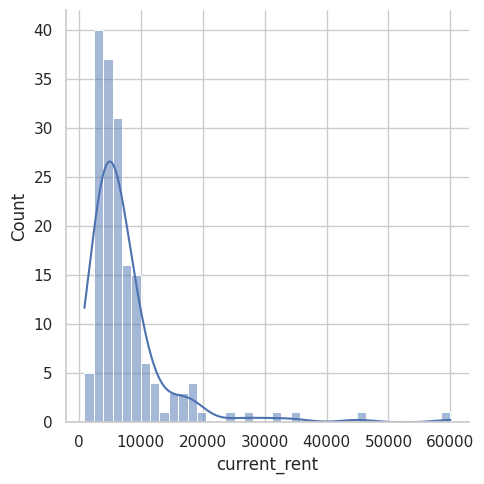

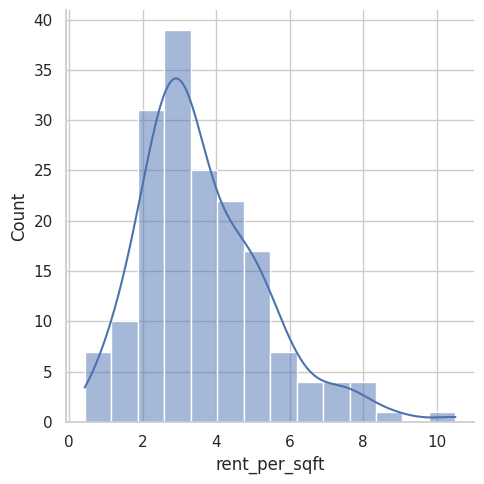

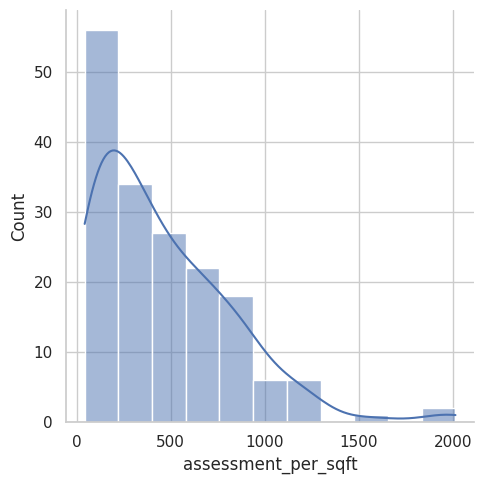

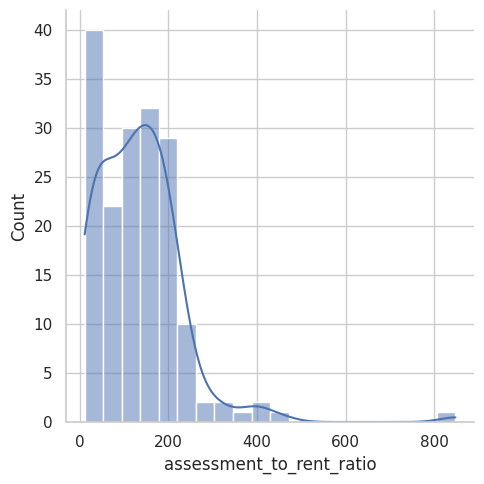

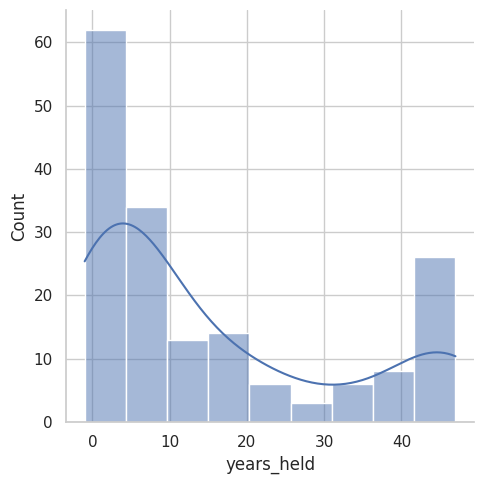

In [13]:
# loop through each column and plot a displot
for column in [
    "current_rent",
    "rent_per_sqft",
    "assessment_per_sqft",
    "assessment_to_rent_ratio",
    "years_held",
]:
    sns.displot(df[column], kde=True)

Text(0.5, 1.04, 'Tax Assessment per sqft vs. Rent per sqft\nPadmapper rental ads in Los Angeles')

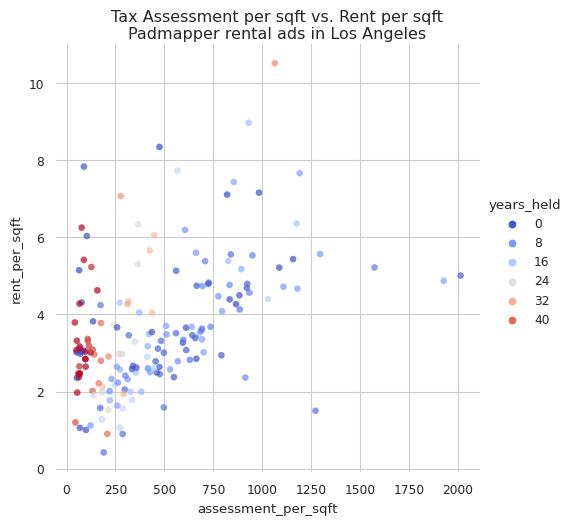

In [51]:
sns.set_theme(style="whitegrid")
sns.set_context('paper')

cmap = sns.color_palette("coolwarm", as_cmap=True)
# cmap = sns.color_palette("flare", as_cmap=True)
# cmap = sns.color_palette("dark:salmon_r", as_cmap=True)
#cmap = sns.color_palette()

g = sns.relplot(
    data=df,
    x="assessment_per_sqft",
    y="rent_per_sqft",
    hue="years_held",
    linewidth=0,
    alpha=0.7,
    palette=cmap,
)
g.despine(left=True, bottom=True)
plt.suptitle("Tax Assessment per sqft vs. Rent per sqft\nPadmapper rental ads in Los Angeles", y=1.04)

In [99]:
hex_cmap = sns.color_palette("coolwarm", n_colors=len(set(df.years_held))).as_hex()
def get_color(x):
    for idx,years in enumerate(sorted(set(df.years_held))):
        if x == years:
            return hex_cmap[max(0,idx)]
df['gmap_color'] = df['years_held'].map(get_color)

df['assessment_to_rent_ratio'] = df['assessment_to_rent_ratio'].round(2)
print(df[['glat', 'glng', 'gmap_color', 'gaddress', 'current_rent', 'current_assessment', 'assessment_to_rent_ratio', "BaseValue_Year", 'lagov', 'screenshot']].to_csv(sep='|', index=False))

glat|glng|gmap_color|gaddress|current_rent|current_assessment|assessment_to_rent_ratio|BaseValue_Year|lagov|screenshot
34.0876285|-117.7255624|#e0dbd8|458 Geneva Ave, Claremont, CA 91711, USA|2950.0|269809.0|91.46|2002|https://portal.assessor.lacounty.gov/parceldetail/8316005016|https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-04-02/458_Geneva_Ave,_Claremont,_CA_91711,_USA.png
34.1199956|-118.1618812|#c5d6f2|526 Floral Park Terrace, S Pasadena, CA 91030, USA|5500.0|1069336.0|194.42|2007|https://portal.assessor.lacounty.gov/parceldetail/5317037006|https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-04-02/526_Floral_Park_Terrace,_S_Pasadena,_CA_91030,_USA.png
34.2167539|-118.3502624|#e0dbd8|10045 W Chardonnay Ct, Sun Valley, CA 91352, USA|4800.0|531483.0|110.73|2002|https://portal.assessor.lacounty.gov/parceldetail/2403029006|https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-04-02/10045_W_Chardonnay_Ct,_Sun_Valley,_CA_91352,_USA.png
34

In [61]:
df

gaddress  current_rent  \
0             458 Geneva Ave, Claremont, CA 91711, USA        2950.0   
1    526 Floral Park Terrace, S Pasadena, CA 91030,...        5500.0   
2     10045 W Chardonnay Ct, Sun Valley, CA 91352, USA        4800.0   
3        6627 Birchton Ave, Canoga Park, CA 91307, USA        6350.0   
4          17328 Keswick St, Northridge, CA 91325, USA        4800.0   
..                                                 ...           ...   
206          7321 Allengrove St, Downey, CA 90240, USA        4000.0   
207     5346 E Scrivener St, Long Beach, CA 90808, USA        4495.0   
208     3541 E 60th Pl, Huntington Park, CA 90255, USA        2650.0   
209  1900 N Poinsettia Ave, Manhattan Beach, CA 902...        6500.0   
210   17604 Garden House Ln, Bellflower, CA 90706, USA        1900.0   

          glat        glng                   bedbath NumOfBeds NumOfBaths  \
0    34.087629 -117.725562  3 Bedrooms · 2 Bathrooms         3          2   
1    34.119996 -118.161881   3 Bedrooms · 1 Bathroom         2          2   
2    34.216754 -118.350262  4 Bedrooms · 3 Bathrooms         3          3   
3    34.190662 -118.641677  4 Bedrooms · 2 Bathrooms         4          2   
4    34.209421 -118.511011  4 Bedrooms · 3 Bathrooms         3          2   
..         ...         ...                       ...       ...        ...   
206  33.969265 -118.129964  3 Bedrooms · 2 Bathrooms         3          2   
207  33.814363 -118.127661  3 Bedrooms · 2 Bathrooms         3          2   
208  33.986177 -118.201147   2 Bedrooms · 1 Bathroom         2          1   
209  33.892422 -118.400223   3 Bedrooms · 1 Bathroom         3          2   
210  33.872838 -118.119353    1 Bedroom · 1 Bathroom         2          4   

       sqft BaseValue_Year CurrentRoll_BaseYear  current_assessment  \
0    1489.0           2002                 2022            269809.0   
1    1575.0           2007                 2022           1069336.0   
2    2392.0           2002                 2022            531483.0   
3    1570.0           2010                 2022            583847.0   
4    1621.0           1981                 2022            229484.0   
..      ...            ...                  ...                 ...   
206  1207.0           2019                 2022            583402.0   
207  1346.0           2018                 2022            803077.0   
208   802.0           1979                 2022             88067.0   
209  1533.0           2018                 2022            266512.0   
210  2114.0           2019                 2022            606355.0   

     rent_per_sqft  assessment_per_sqft  assessment_to_rent_ratio  years_held  \
0         1.981195           181.201478                 91.460678          20   
1         3.492063           678.943492                194.424727          15   
2         2.006689           222.191890                110.725625          20   
3         4.044586           371.877070                 91.944409          12   
4         2.961135           141.569402                 47.809167          41   
..             ...                  ...                       ...         ...   
206       3.314002           483.348799                145.850500           3   
207       3.339525           596.639673                178.660067           4   
208       3.304239           109.809227                 33.232830          43   
209       4.240052           173.849967                 41.001846           4   
210       0.898770           286.828288                319.134211           3   

    gmap_color  
0      #4257c9  
1      #4257c9  
2      #4257c9  
3      #4257c9  
4      #4257c9  
..         ...  
206    #4257c9  
207    #4257c9  
208    #4257c9  
209    #4257c9  
210    #4257c9  

[172 rows x 16 columns]